# 第8章 提升方法

配置环境：python 3.6

代码全部测试通过。

代码参考 : https://github.com/wzyonggege/statistical-learning-method/blob/master/AdaBoost/Adaboost.ipynb

此文档方便阅读，若需要复制粘贴可以在当前目录中查看`AdaBoost.py`

In [37]:
import numpy as np
import math
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [58]:
# 生成数据
def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = ['sepal length', 'sepal width',
                  'petal length', 'petal width', 'label']
    data = np.array(df.iloc[:100, [0, 1, -1]])
    for i in range(len(data)):
        if data[i, -1] == 0:
            data[i, -1] = -1
    return data[:, :2], data[:, -1]

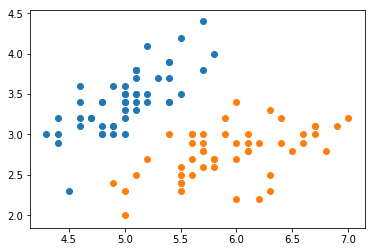

In [65]:
X, y = create_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
plt.scatter(X[:50, 0], X[:50, 1], label='0')
plt.scatter(X[50:, 0], X[50:, 1], label='1')

In [68]:
class AdaBoost():
    def __init__(self, cls_num=100, lr=0.1):
        self.cls_num = cls_num
        self.lr = lr
    
    def load_data(self, X, y):
        self.X = X
        self.y = y

    def init_args(self):
        self.sample_num, self.feature_num = self.X.shape
        self.alpha = [0] * self.cls_num
        # 初始化权重 书上公式 算法 8.1 (1)
        self.w = [1.0 / self.sample_num] * self.sample_num
        # self.clf_sets[]
        # 保存每一层的参数，(axis, v, direct)
        # axis 是哪个特征比如 x0
        # v 是阈值
        # direct 在后面解释
        self.clf_sets = []

    def cal_error(self, x):
        """
        计算分类误差率，并选取最合适的阈值

        其中我们选择了阈值 v,但是不确定的是比阈值大的时候取 1 还是阈值小的时候取 1 
        所以规定 direct 记录方向
        """
        error, direct, g_array, best_v = float('inf'), '', None, 0.0
        _min = min(x)
        _max = max(x)
        n_step = (_max - _min + self.lr) // self.lr

        # 选取阈值
        t_direct, t_error, t_array = None, None, None
        for i in range(1, int(n_step)):
            v = _min + i * self.lr
            # 保证阈值不在 x 内
            if v not in x:
                # 生成比阈值大为 1 的预测数组
                postive_array = [1 if x[k] > v else -1 for k in range(self.sample_num)]
                # 计算误差
                postive_error = sum([self.w[k] for k in range(self.sample_num) if postive_array[k] != self.y[k]])
                
                # 生成比阈值小为 -1 的预测数组
                nagative_array = [-1 if x[k] > v else 1 for k in range(self.sample_num)]
                nagative_error = sum([self.w[k] for k in range(self.sample_num) if nagative_array[k] != self.y[k]])
                
                # 比较谁的分类效果好
                if postive_error < nagative_error:
                    t_direct = 'postive'
                    t_error = postive_error
                    t_array = postive_array
                else:
                    t_direct = 'negative'
                    t_error = nagative_error
                    t_array = nagative_array
                # 如果当前误差小于已保存的误差
                # 则更新误差
                if error > t_error:
                    error, direct, g_array, best_v = t_error, t_direct, t_array, v
        # 返回误差，方向，预测数组，阈值
        return error, direct, g_array, best_v
                    


    # 计算 alpha
    def cal_alpha(self, idx, error):
        """
        书上公式 8.2
        """
        self.alpha[idx] = (1/2)*math.log((1-error) / error)

    # 计算 Z
    def cal_Z(self, alpha, g_array):
        """
        书上公式 8.5
        """
        Z = 0.0
        for i in range(self.sample_num):
            exp = math.exp(-alpha * self.y[i] * g_array[i])
            Z += self.w[i] * exp

        return Z

    # 更新权值
    def update_w(self, alpha, Z, g_array):
        """
        书上公式 140 最上面
        """
        for i in range(self.sample_num):
            if g_array[i] == self.y[i]:
                self.w[i] = (self.w[i] / Z) * math.exp(-alpha)
            else:
                self.w[i] = (self.w[i] / Z) * math.exp(alpha)

    # 根据每一层的参数，返回预测类别
    def G(self, x, v, direct):
        if direct == 'positive':
            return 1 if x > v else -1 
        else:
            return -1 if x > v else 1 
    
    # 训练
    def fit(self):
        
        for epoch in range(self.cls_num):
            direct = 'positive'
            axis = 0
            min_error, best_v, g_array = float('inf'), 0, None
            # 遍历所有特征，从所有的特征中找到阈值
            for j in range(self.feature_num):
                x = self.X[:, j]
                # 寻找当前特征最好的阈值，以及最小的误差
                error, temp_direct, temp_g_array, v = self.cal_error(x)
                # 如果当前特征的误差小于已保存的误差
                # 则更新误差
                if error < min_error:
                    best_v = v
                    g_array = temp_g_array
                    direct = temp_direct
                    min_error = error
                    axis = j
                # 如果误差为 0 不用继续下去了
                if min_error == 0:
                    break
            # 计算 alpha 书上公式 8.2   
            self.cal_alpha(epoch, error)
            # 计算 Z 书上公式 8.5
            Z = self.cal_Z(self.alpha[epoch], g_array)
            # 添加进弱分类器的数组集合
            self.clf_sets.append((axis, best_v, direct))
            # 更新 权重
            self.update_w(self.alpha[epoch], Z, g_array)

    def predict(self, feature):
        result = 0.0
        for i in range(len(self.clf_sets)):
            axis, clf_v, direct = self.clf_sets[i]
            f_input = feature[axis]
            result += self.alpha[i] * self.G(f_input, clf_v, direct)
        return 1 if result > 0 else -1

    def score(self, X_test, y_test):
        right_count = 0
        for i in range(len(X_test)):
            feature = X_test[i]
            if self.predict(feature) == y_test[i]:
                right_count += 1

        return right_count / len(X_test)


In [69]:
ab = AdaBoost()
ab.load_data(X_train, y_train)
ab.init_args()
ab.fit()

print('score', ab.score(X_train, y_train))


score 0.7466666666666667
